In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/siyuyang/Source/repos/DevOps_AIforGood/nlrc.building-damage-assessment')

In [3]:
import json
import os

from collections import defaultdict
import rasterio.features
import numpy as np
import shapely.geometry
from shapely.geometry import mapping, Polygon
from PIL import Image

from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer

# need to change the path in data/create_label_masks.py file where the label_map_file is loaded
# to an absolute path when running this notebook or add "../" to go one directory up (cwd is in the 'eval' folder)
from data.create_label_masks import get_feature_info, read_json

# Evaluate model output at the building level

This notebook was used to develop `eval_building_level.py` and to create test data - use the script version instead when evaluating the model.

In [30]:
viz = RasterLabelVisualizer(label_map='../constants/class_lists/xBD_label_map.json')

all_classes = set([1, 2, 3, 4, 5])
allowed_classes = set([1, 2, 3, 4])  # 5 is Unclassified, not used during evaluation

### Sample tile
A mask of the ground truth tile

(1024, 1024)

array([0, 3, 4, 5], dtype=uint8)

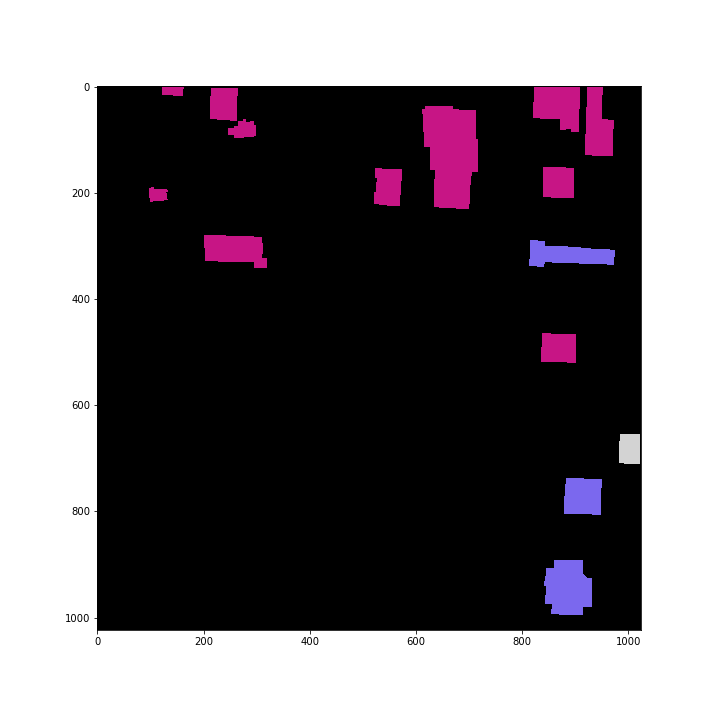

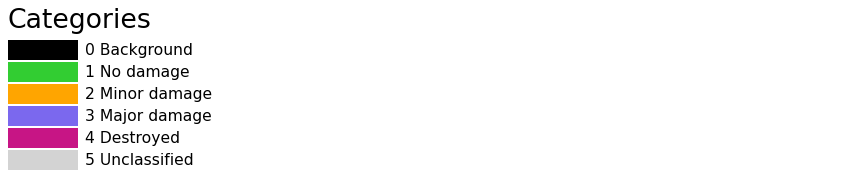

In [5]:
l = viz.plot_color_legend()

p = 'test_data/joplin-tornado_00000050_post_disaster_b1.png'
p_np = np.array(Image.open(p))
p_np.shape
np.unique(p_np)

im, buf = viz.show_label_raster(p_np, size=(10, 10))
im

### Create a test tile from the sample with corner cases

Manipulate the above tile to get one where one building blob contains pixels of multiple classes

(1024, 1024)

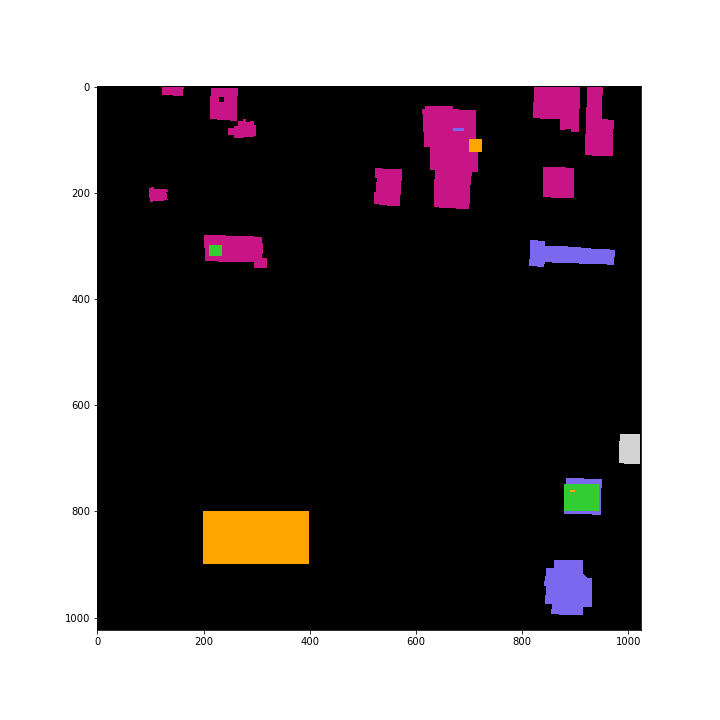

In [8]:
new_test_tile_np = np.array(Image.open(p))
new_test_tile_np.shape

new_test_tile_np[100:125, 700:725] = 2  # should remain classed as class 4
new_test_tile_np[80:85, 670:690] = 3

new_test_tile_np[300:320, 210:235] = 1  # should remain classed as class 4

new_test_tile_np[750:800, 880:945] = 1  # should be classed as class 1
new_test_tile_np[760:765, 890:900] = 2

# a hole of background class - to test the blob-forming logic
new_test_tile_np[20:30, 230:240] = 0

# a false positive
new_test_tile_np[800:900, 200:400] = 2

# a false negative - cover one building in black pixels
new_test_tile_np[400:600, 800:1000] = 0

im, buf = viz.show_label_raster(new_test_tile_np, size=(10, 10))
im

new_test_tile = Image.fromarray(new_test_tile_np)
new_test_tile.save('test_data/test_tile_0.png')

### Label polygons

In [9]:
json_post = read_json('test_data/joplin-tornado_00000050_post_disaster.json')

In [10]:
polys = get_feature_info(json_post)

In [11]:
label_polygons_and_class = []  # tuples of (shapely polygon, damage_class_num)

for uid, tup in polys.items():
    poly, damage_class_num = tup # poly is a np.ndarray
    polygon = Polygon(poly)
    
    if damage_class_num in allowed_classes:
        label_polygons_and_class.append((polygon, damage_class_num))

In [12]:
len(label_polygons_and_class)

14

### Predicted polygons

Test with a mask produced from the labels for training

In [13]:
mask_post = np.asarray(Image.open('test_data/test_tile_0.png'))

In [14]:
mask_post.shape
mask_post.dtype

(1024, 1024)

dtype('uint8')

Method

1. Detect the connected components by all non-background classes to determine the predicted building blobs first (if we do this per class, a building with some pixels predicted to be in another class will result in more buildings than connected components)
2. The majority class for each building blob is assigned to be that building's predicted class.

In [24]:
background_and_others_mask = np.where(mask_post > 0, 1, 0).astype(np.int16)  # all non-background classes become 1

# rasterio.features.shapes:
# default is 4-connected for connectivity - see https://www.mathworks.com/help/images/pixel-connectivity.html
# specify the `mask` parameter, otherwise the background will be returned as a shape
connected_components = rasterio.features.shapes(background_and_others_mask, mask=mask_post > 0)

polygons = []
for component_geojson, pixel_val in connected_components:
    
    # reference: https://shapely.readthedocs.io/en/stable/manual.html#python-geo-interface
    shape = shapely.geometry.shape(component_geojson)
    assert isinstance(shape, Polygon)
    polygons.append(shape)

len(polygons)  # 15: we took away one and added one (14), and one polygon is of the Unclassified class

15

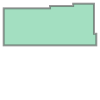

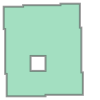

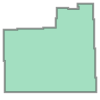

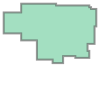

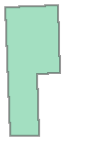

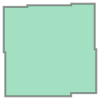

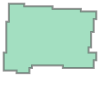

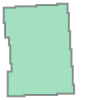

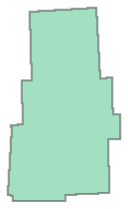

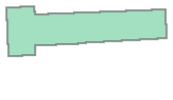

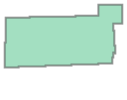

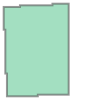

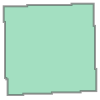

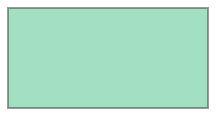

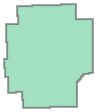

In [25]:
for p in polygons:  # flipped when visualized this way
    p

In [31]:
polygons_by_class = []

for c in all_classes:
    
    # default is 4-connected for connectivity
    shapes = rasterio.features.shapes(mask_post, mask=mask_post == c)

    for shape_geojson, pixel_val in shapes:
        
        shape = shapely.geometry.shape(shape_geojson)
        assert isinstance(shape, Polygon)
        polygons_by_class.append((shape, int(pixel_val)))

len(polygons_by_class)  # 20 shapes including the one of class Unclassified

20

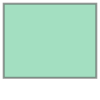

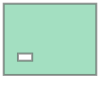

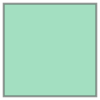

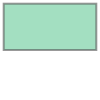

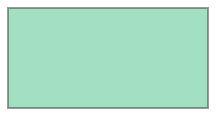

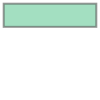

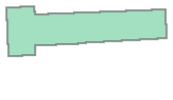

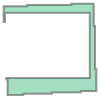

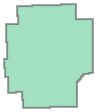

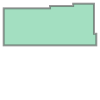

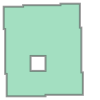

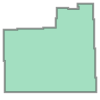

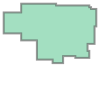

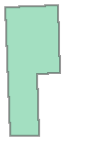

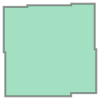

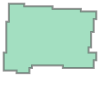

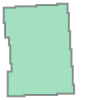

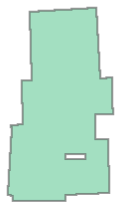

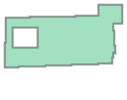

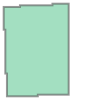

In [32]:
for p in polygons_by_class:  # flipped when visualized this way
    p[0]

In [48]:
# we take the class of the shape with the maximum overlap with the building polygon to be the class of the building - majority vote
polygons_max_overlap = [0.0] * len(polygons)  # indexed by polygon_i
polygons_max_overlap_class = [None] * len(polygons)

assert isinstance(polygons, list)  # need the order constant

for polygon_i, polygon in enumerate(polygons):
    for shape, shape_class in polygons_by_class:
        intersection_area = polygon.intersection(shape).area
        if intersection_area > polygons_max_overlap[polygon_i]:
            polygons_max_overlap[polygon_i] = intersection_area
            polygons_max_overlap_class[polygon_i] = shape_class

pred_polygons_and_class = []  # include all classes

for polygon_i, (max_overlap_area, clss) in enumerate(zip(polygons_max_overlap, polygons_max_overlap_class)):
    pred_polygons_and_class.append(
        (polygons[polygon_i], clss)
    )
len(pred_polygons_and_class)

15

In [50]:
for polygon, clss in pred_polygons_and_class:
    print(f'area: {polygon.area}, class {clss}')

area: 657.0, class 4
area: 2988.0, class 4
area: 6100.0, class 4
area: 1307.0, class 4
area: 5386.0, class 4
area: 3334.0, class 4
area: 800.0, class 4
area: 3337.0, class 4
area: 16438.0, class 4
area: 5357.0, class 3
area: 5687.0, class 4
area: 2166.0, class 5
area: 4650.0, class 1
area: 20000.0, class 2
area: 7687.0, class 3


### Matching predicted and label polygons

Method
- For each predicted polygon, we find the maximum value of IoU it has with any ground truth polygon within the tile. This ground truth polygon is its "match".
- Using the threshold IoU specified (typically and by default 0.5), if a prediction has overlap above the threshold AND the correct class, it is considered a true positive. All other predictions, no matter what their IOU is with any gt, are false positives.
       - Note that it is possible for one ground truth polygon to be the match for multiple predictions, especially if the IoU threshold is low, but each prediction only has one matching ground truth polygon.
- For ground truth polygon not matched by any predictions, it is a false negative.
- Given the TP, FP, and FN counts for each class, we can calculate the precision and recall for each tile *for each class*.


- To plot a confusion table, we output two lists, one for the predictions and one for the ground truth polygons (because the set of polygons to confuse over are not the same...)
1. For the list of predictions, each item is associated with the ground truth class of the polygon that it matched, or a "false positive" attribute.
2. For the list of ground truth polygons, each is associated with the predicted class of the polygon it matched, or a "false negative" attribute.

In [51]:
# DRAFT - see eval_building_level.py

def _evaluate_tile(pred_polygons_and_class: list, 
                  label_polygons_and_class: list,
                  allowed_classes,
                  iou_threshold: float=0.5):
    
    # the matched label polygon's IoU with the pred polygon, and the label polygon's index
    pred_max_iou_w_label = [(0.0, None)] * len(pred_polygons_and_class)
    
    for i_pred, (pred_poly, pred_class) in enumerate(pred_polygons_and_class):
        
        # cannot skip pred_class if it's not in the allowed list, as the list above relies on their indices
        
        for i_label, (label_poly, label_class) in enumerate(label_polygons_and_class):

            intersection = pred_poly.intersection(label_poly)
            union = pred_poly.union(label_poly)  # they should not have zero area
            iou = intersection.area / union.area
            
            if iou > pred_max_iou_w_label[i_pred][0]:
                pred_max_iou_w_label[i_pred] = (iou, i_label)
        
    results = defaultdict(lambda: defaultdict(int))  # class: {tp, fp, fn} counts
    
    i_label_polygons_matched = set()
    list_preds = []
    list_labels = []
    
    for i_pred, (pred_poly, pred_class) in enumerate(pred_polygons_and_class):
        
        if pred_class not in allowed_classes:
            continue

        max_iou, matched_i_label = pred_max_iou_w_label[i_pred]
        
        if matched_i_label is not None:
            i_label_polygons_matched.add(matched_i_label)
        
        item = {
            'pred': pred_class,
            'label': label_polygons_and_class[matched_i_label][1] if matched_i_label is not None else None
        }
        list_preds.append(item)
        list_labels.append(item)
        
        if max_iou > iou_threshold and label_polygons_and_class[matched_i_label][1] == pred_class:
            # true positive
            results[pred_class]['tp'] += 1
        else:
            # false positive - all other predictions
            results[pred_class]['fp'] += 1  # note that it is a FP for the prediction's class
            
    # calculate the number of false negatives - how many label polygons are not matched by any predictions
    for i_label, (label_poly, label_class) in enumerate(label_polygons_and_class):
        
        if label_class not in allowed_classes:
            continue
        
        if i_label not in i_label_polygons_matched:
            results[label_class]['fn'] += 1
            list_labels.append({
                'pred': None,
                'label': label_class
            })
    
    return results, list_preds, list_labels

In [52]:
results, list_preds, list_labels = _evaluate_tile(pred_polygons_and_class, 
                                                 label_polygons_and_class,
                                                  allowed_classes)

In [55]:
for clss, res in results.items():
    print(clss)
    print(res)
    print()

4
defaultdict(<class 'int'>, {'tp': 10, 'fn': 1})

3
defaultdict(<class 'int'>, {'tp': 2})

1
defaultdict(<class 'int'>, {'fp': 1})

2
defaultdict(<class 'int'>, {'fp': 1})



In [ ]:
list_preds

In [ ]:
list_labels